# Comparing gradient computation methods
- Finite differences in numpy
- Manual Backpropagation in numpy
- Jax's value_and_grad
- Pytorch .backward()

In [1]:
import numpy as np
import jax

/Users/peterwhidden/miniconda3/lib/python3.9/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


Create shorthand for initialing random tensors

In [2]:
ts = 3 # 3

def r(x, y=None, z=None):
    if y is None:
        return np.random.randn(x)
    elif z is None:
        return np.random.randn(x, y)
    else:
        return np.random.randn(x, y, z)

Create some random matrices / vectors for testing 

In [3]:
target = np.array([0.2, 0.3, 0.5]) # simple arbitrary target distribution
noise = r(ts) # random offset vector
params = r(ts, ts) # random matrix 

Define a test function which we will be computing the gradient of. It vaugely resembles a classifier with MSE loss but differs intentionally simply for the sake of working equations that haven't been used before.

In [4]:
def test_func(ga, b, target):
    first_p = (ga @ b)**2
    normed = first_p / first_p.sum()
    return ((normed - target)**2).mean()

test_func_bound = lambda ga: test_func(ga, noise, target)

We can actually implement jax's value_and_grad function transformation with just a few lines using finite differences. This will be extremely inefficient however when computing the gradient of a large number of parameters

In [5]:
def finite_diff_value_and_grad(func):
    def grad_f(ga):
        eps = 0.000001
        grad = np.zeros(ga.shape)
        for i in range(ga.shape[0]):
            for j in range(ga.shape[0]):
                delta_mat = np.zeros(ga.shape)
                delta_mat[i][j] = eps
                bumped = ga + delta_mat
                grad[i][j] = (func(bumped) - func(ga)) / eps
        return grad
    return lambda x: (func(x), grad_f(x))

A slight variation of the previous function which is even less efficient (because of reshaping in the loop) but can handle arbitrary input shapes

In [6]:
def finite_diff_value_and_grad_v2(func):
    def grad_f(ga):
        eps = 0.000001
        grad = np.zeros(ga.size)
        bumped = ga.flatten()
        for i in range(ga.size):
            bumped[i] += eps
            grad[i] = (func(bumped.reshape(ga.shape)) - func(ga)) / eps
            bumped[i] -= eps
        return grad.reshape(ga.shape)
    return lambda x: (func(x), grad_f(x))

Manually implement reverse-mode autodiff (backpropagation) for our function using the chain rule

In [7]:
def test_func_grad_backprop(a, b, target, debug=False):
    # same calculations as test_func but broken down into individual operations
    c = (a @ b)
    v = c**2
    f = v.sum()
    h = v / f
    k = h - target
    m = k**2
    n = m.sum()
    w = n / m.shape[0]
    
    dw_dw = 1
    if debug:
        print(f'dw_dw: {dw_dw}')
    
    dw_dn = dw_dw * (1 / m.shape[0])
    if debug:
        print(f'dw_dn: {dw_dn}')
    
    dw_dm = dw_dn * 1
    if debug:
        print(f'dw_dm: {dw_dm}')
    
    dw_dk = dw_dm * 2 * k
    if debug:
        print(f'dw_dk: {dw_dk}')
    
    dw_dh = dw_dk * 1 # skip target
    if debug:
        print(f'dw_dh: {dw_dh}')
    
    # quotient rule, f = g(x)/h(x) -> f'(x) = g'(x)*h(x)-g(x)*h'(x) / h(x)^2
    dw_df = (dw_dh * (-v / f**2)).sum()
    if debug:
        print(f'dw_df: {dw_df}')
    
    dw_dv = dw_df * 1 + dw_dh * (1 / f)
    if debug:
        print(f'dw_dv: {dw_dv}')

    dw_dc = dw_dv * 2 * c 
    if debug:
        print(f'dw_dc: {dw_dc}')
    
    dw_da = np.outer(dw_dc, b)
    return w, dw_da

test_func_grad_backprop_bound = lambda ga: test_func_grad_backprop(ga, noise, target)
    

Do the same computation in pytorch so we can render a computation graph and compare the gradients for each variable 

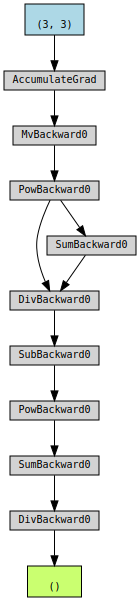

In [8]:
import torch
import torchviz

a = torch.tensor(params)
a.requires_grad = True
b = torch.tensor(noise)
targ = torch.tensor(target)
c = (a @ b)
c.retain_grad()
d = c**2
d.retain_grad()
f = d.sum()
f.retain_grad()
h = d / f
h.retain_grad()
k = h - targ
k.retain_grad()
m = k**2
m.retain_grad()
n = m.sum()
n.retain_grad()
w = n / m.shape[0]
w.retain_grad()
w.backward()

grads = {
    'w': w.grad,
    'n': n.grad,
    'm': m.grad,
    'k': k.grad,
    'h': h.grad,
    'f': f.grad,
    'd': d.grad,
    'c': c.grad,
    'a': a.grad
}

torchviz.make_dot(w)

Show gradients computed by pytorch

In [9]:
for k,v in grads.items():
    print(f'{k}: {v}')

w: 1.0
n: 0.3333333333333333
m: tensor([0.3333, 0.3333, 0.3333], dtype=torch.float64)
k: tensor([-0.0998, -0.1585,  0.2583], dtype=torch.float64)
h: tensor([-0.0998, -0.1585,  0.2583], dtype=torch.float64)
f: -0.19138725495718847
d: tensor([-0.2805, -0.3329,  0.0392], dtype=torch.float64)
c: tensor([0.1331, 0.1758, 0.0782], dtype=torch.float64)
a: tensor([[ 0.0032,  0.0586, -0.0690],
        [ 0.0043,  0.0774, -0.0911],
        [ 0.0019,  0.0345, -0.0406]], dtype=torch.float64)


Verify our manually computed gradients match

In [10]:
test_func_grad_backprop(params, noise, target, debug=True)

dw_dw: 1
dw_dn: 0.3333333333333333
dw_dm: 0.3333333333333333
dw_dk: [-0.09983595 -0.15849892  0.25833487]
dw_dh: [-0.09983595 -0.15849892  0.25833487]
dw_df: -0.19138725495718845
dw_dv: [-0.28051157 -0.33288046  0.03923027]
dw_dc: [0.13309974 0.17580814 0.07823145]


(0.07636952210140206,
 array([[ 0.00322676,  0.05861361, -0.06899421],
        [ 0.00426215,  0.07742126, -0.09113274],
        [ 0.00189658,  0.03445106, -0.04055242]]))

Verify jax's value_and_grad gives the same results

In [11]:
jax.value_and_grad(test_func_bound)(params)

NameError: name 'test_auto_func' is not defined

Verify both our finite difference methods also give the same results

In [ ]:
finite_diff_value_and_grad(test_func_bound)(params)

In [ ]:
finite_diff_value_and_grad_v2(test_func_bound)(params)

Implement gradient descent

In [ ]:
def optimize(params, grad_method, func):
    weights = params.copy()
    for i in range(1000):
        loss, grad_val = grad_method(func)(weights)
        weights -= 0.03 * grad_val
        if (i % 100 == 0):
            print(f'step {i}: loss: {loss}')

Test all of our gradient methods with the optimizer

In [ ]:
optimize(params, jax.value_and_grad, test_func_bound)

In [ ]:
#%%timeit
optimize(params, finite_diff_value_and_grad, test_func_bound)

In [ ]:
#%%timeit
optimize(params, finite_diff_value_and_grad_v2, test_func_bound)

In [ ]:
#%%timeit
optimize(params, lambda _: lambda p: test_func_grad_backprop(p, noise, target), None)